# GP+PCA detrended WLCs

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import bz2
import corner
import json
import pathlib
import pickle
import utils
import warnings

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = utils.plot_params()
plt.rcParams.update(params)

## [Dowload data](https://www.dropbox.com/sh/n2mlcmsi9e3g0t6/AAB8n5PKb9MzGq3-BN33Okppa?dl=1)

Unzip this into a folder named `data` in the same level as this notebook

## Plot

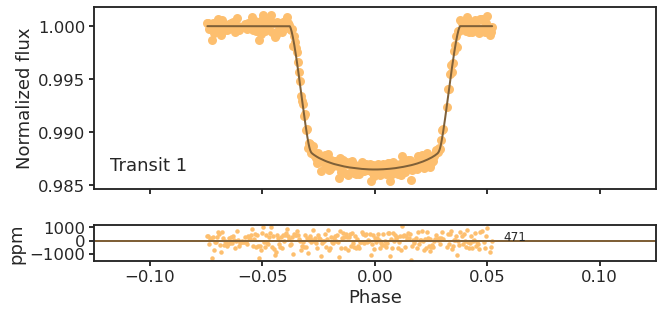

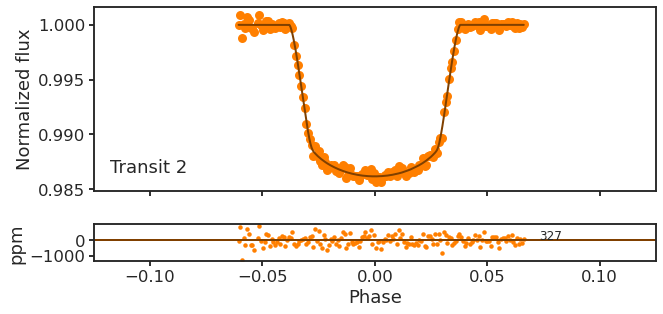

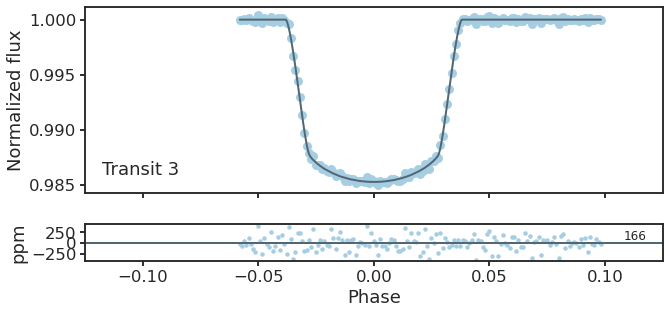

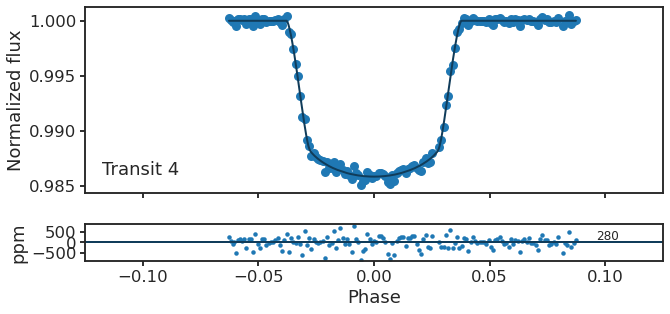

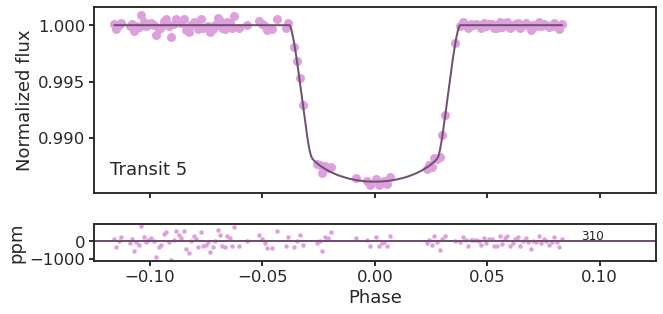

In [19]:
data_dir = "data/detrended_wlcs"
fpaths = sorted(glob.glob(f"{data_dir}/hp*/white-light"))
fpath_dict = {f"Transit {i}": fpath for (i, fpath) in enumerate(fpaths, start=1)}
PCA = "PCA_2"  # Total number of principal components

for i, (transit_name, dirpath) in enumerate(fpath_dict.items()):
    fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [5, 1]})
    ax_top, ax_bottom = axes

    # Get t0, P
    fpath_t0 = f"{dirpath}/results.dat"
    df_results = pd.read_table(fpath_t0, sep="\s+", index_col=0, escapechar="#")
    t0, P = df_results.loc[["t0", "P"]]["Value"]

    fpath = f"{dirpath}/{PCA}/detrended_lc.dat"

    # Detrended data
    t, detflux, detflux_err, model = np.genfromtxt(fpath, unpack=True)
    phase = utils.get_phases(t, P, t0)
    ax_top.plot(phase, detflux, "o", label=transit_name, c=f"C{i}", mew=0)
    c_dark = 0.5 * np.array(mpl.colors.to_rgba(f"C{i}")[:3])
    trans = transforms.blended_transform_factory(ax_top.transAxes, ax_top.transAxes)
    ax_top.annotate(transit_name, xy=(0.03, 0.1), xycoords=trans, weight="normal")

    # Full model
    t_full, f_full = np.genfromtxt(f"{dirpath}/full_model_{PCA}.dat").T
    phase_full = utils.get_phases(t_full, P, t0)
    p = ax_top.plot(phase_full, f_full, color=c_dark, lw=2, zorder=10)

    # Residuals
    c = 2 * c_dark
    resids = detflux - model
    ax_bottom.plot(phase, resids * 1e6, ".", mew=0, color=c)
    trans = transforms.blended_transform_factory(
        ax_bottom.transData, ax_bottom.transAxes
    )
    ax_bottom.axhline(0, lw=2, c=c_dark)

    rms = np.std(resids * 1e6)
    ax_bottom.annotate(
        f"{int(rms)}", xy=(1.1 * phase[-1], 0.58), xycoords=trans, fontsize=12
    )

    # Save
    ax_top.set_xlim(-0.125, 0.125)
    ax_bottom.set_xlabel("Phase")
    ax_top.set_ylabel("Normalized flux")
    ax_bottom.set_ylabel("ppm")
    fig.tight_layout()
    fig.set_size_inches(FIG_WIDE)
    title = transit_name.lower().replace(" ", "_") + "_detr_wlcs"
    utils.savefig(f"../paper/figures/detrended_wlcs/{title}.pdf")

## Fitted parameters table

In [6]:
data_dict = {k:f"{v}/results.dat" for k, v in fpath_dict.items()}

# Truths from Sada and Ramon (2016) + GAIA DR2
with open(f"data/detrended_wlcs/truth.json", "rb") as f:
    parameters = json.load(f)

parameters["d"] = {
    "symbol": "$\delta$",
    "truth": [0.1113**2 * 1e6, 0.001**2 * 1e6, 0.0009**2 * 1e6],
    "definition": "transit depth (ppm)"
}

# Holds results from each transit
results = {}
for transit, fpath in data_dict.items():
    results[transit] = pd.read_table(fpath, sep='\s+', index_col="Variable")
    results[transit].loc["t0"]["Value"] -= 2450000
    p_val, p_u, p_d = results[transit].loc["p"].values.T
    results[transit].loc["d"] = p_val**2 * 1e6, 2e6 * p_val * p_u, 2e6 * p_val * p_d

# Create summary table of all transits
results_dict = {}
results_dict["parameter"] = [p["symbol"] for p in parameters.values()]
#results_dict['definition'] = [p["definition"] for p in parameters.values()]
for transit, results in results.items():
    results_dict[transit] = []
    for param, param_info in parameters.items():
        if param == "P":
            fmt_vals = {"fmt_v":".5f", "fmt_vu":".3g", "fmt_vd":".3g"}
        else:
            fmt_vals = {"fmt_v":".5f", "fmt_vu":".5f", "fmt_vd":".5f"}
        results_dict[transit].append(
            utils.write_latex_row(results.loc[param], **fmt_vals)
        )
        
results_table = pd.DataFrame(results_dict)
results_table#.to_clipboard(index=False)

,parameter,Transit 1,Transit 2,Transit 3,Transit 4,Transit 5
0,$R_\mathrm{p}/R_\mathrm{s}$,0.11218^{+0.00283}_{-0.00289},0.11277^{+0.00187}_{-0.00204},0.11650^{+0.00257}_{-0.00279},0.11491^{+0.00206}_{-0.00202},0.11328^{+0.00202}_{-0.00216}
1,$t_0$,4852.26537^{+0.00015}_{-0.00015},4852.26540^{+0.00014}_{-0.00014},4852.26541^{+0.00014}_{-0.00013},4852.26545^{+0.00015}_{-0.00015},4852.26543^{+0.00013}_{-0.00014}
2,$P$,1.21289^{+1.13e-07}_{-1.14e-07},1.21289^{+8.45e-08}_{-8.76e-08},1.21289^{+8.76e-08}_{-8.78e-08},1.21289^{+7.42e-08}_{-7.84e-08},1.21289^{+7e-08}_{-7.13e-08}
3,$\rho_\mathrm{s}$,1.07230^{+0.08406}_{-0.07603},0.96894^{+0.06463}_{-0.05683},1.01504^{+0.05602}_{-0.05063},1.03666^{+0.06581}_{-0.06079},1.02626^{+0.07229}_{-0.07204}
4,$i$,84.33384^{+0.88921}_{-0.80101},83.14471^{+0.73406}_{-0.61691},83.64261^{+0.56957}_{-0.51338},83.76319^{+0.69346}_{-0.64068},83.73923^{+0.73109}_{-0.74358}
5,$b$,0.43173^{+0.04848}_{-0.05892},0.50417^{+0.03445}_{-0.04412},0.47517^{+0.02969}_{-0.03537},0.46904^{+0.03843}_{-0.04320},0.46936^{+0.04278}_{-0.04503}
6,$a/R_\mathrm{s}$,4.36890^{+0.11130}_{-0.10580},4.22377^{+0.09190}_{-0.08424},4.28971^{+0.07750}_{-0.07254},4.31996^{+0.08955}_{-0.08614},4.30547^{+0.09880}_{-0.10320}
7,$u$,0.24859^{+0.10290}_{-0.10754},0.38699^{+0.07698}_{-0.07472},0.37032^{+0.10186}_{-0.11732},0.40126^{+0.08643}_{-0.09298},0.32686^{+0.07151}_{-0.08796}
8,$\delta$,12584.79890^{+633.98979}_{-647.93827},12716.26467^{+421.08962}_{-459.31331},13571.18577^{+598.68259}_{-650.42694},13204.48610^{+472.94430}_{-465.37117},12831.57340^{+456.65963}_{-489.88214}
